# Preprocessing & EDA Notebook


This notebook performs initial data exploration, cleaning, and preparation steps for the project.



## Library Imports

Importing required Python libraries:
- `pandas`: For data manipulation and analysis
- `matplotlib.pyplot` & `seaborn`: For data visualization
- `Counter`: For counting unique elements
- `re`: For regular expression operations

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re


## Data Loading

Loading the raw medical reports dataset from 'indiana_reports.csv' into a pandas DataFrame.

In [2]:
# Load DataFrame
df = pd.read_csv("indiana_reports.csv")

## Data Quality Check

Checking for null values in each column to understand data completeness.

In [ ]:
# check for null values
df.isnull().sum()

uid              0
MeSH             0
Problems         0
image            0
indication      86
comparison    1166
findings       514
impression      31
dtype: int64

## Text Length Analysis

Analyzing the length distribution of texts in the `findings` and `impression` fields:

1. Calculate character counts for each field
2. Visualize length distributions using histograms
3. Generate summary statistics (min, max, mean, median, standard deviation)

This helps identify potential outliers and understand text length patterns.

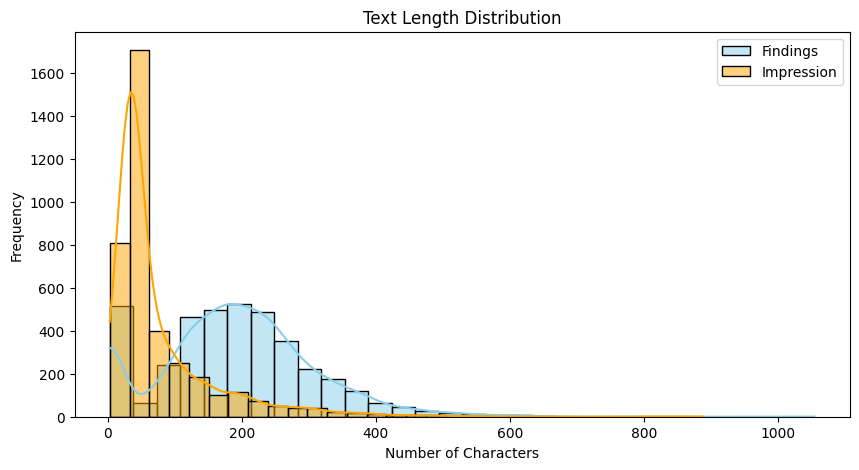


 Stats for findings:
  Min: 3
  Max: 1054
  Mean: 190.64
  Median: 188.0
  Std Dev: 117.50

 Stats for impression:
  Min: 3
  Max: 887
  Mean: 76.23
  Median: 39.0
  Std Dev: 82.52


In [4]:
# Add length columns
df['findings_len'] = df['findings'].astype(str).apply(len)
df['impression_len'] = df['impression'].astype(str).apply(len)

# Plot histogram
plt.figure(figsize=(10,5))
sns.histplot(df['findings_len'], bins=30, kde=True, color='skyblue', label='Findings')
sns.histplot(df['impression_len'], bins=30, kde=True, color='orange', label='Impression')
plt.legend()
plt.title("Text Length Distribution")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()

# Print summary statistics
for col in ['findings_len', 'impression_len']:
    print(f"\n Stats for {col.replace('_len', '')}:")
    print(f"  Min: {df[col].min()}")
    print(f"  Max: {df[col].max()}")
    print(f"  Mean: {df[col].mean():.2f}")
    print(f"  Median: {df[col].median()}")
    print(f"  Std Dev: {df[col].std():.2f}")


## Common Phrases Analysis

Extracting and analyzing the most frequent phrases starting with 'no acute' in the impression field. This helps understand common medical observations in the reports.

In [5]:
# Show most frequent phrases
df['impression'].dropna().str.lower().str.extract(r'(no acute.*?)\.').value_counts().head(10)


0                                              
no acute cardiopulmonary abnormality               491
no acute cardiopulmonary findings                  189
no acute cardiopulmonary abnormalities             168
no acute cardiopulmonary disease                   163
no acute disease                                   126
no acute cardiopulmonary process                   106
no acute radiographic cardiopulmonary process       93
no acute cardiopulmonary abnormality identified     80
no acute pulmonary disease                          76
no acute findings                                   60
Name: count, dtype: int64

## Field Completeness Analysis

Calculating the proportion of records that have non-null values for each field (`indication`, `comparison`, `MeSH`, `Problems`). This helps understand data availability across different fields.

In [6]:
# Check proportion of records with each field
fields = ['indication', 'comparison', 'MeSH', 'Problems']
df[fields].notnull().mean().sort_values(ascending=False)


MeSH          1.000000
Problems      1.000000
indication    0.977668
comparison    0.697222
dtype: float64

## Vocabulary Analysis

Analyzing the vocabulary in the dataset:
1. Define a tokenization function to extract words
2. Process both findings and impressions
3. Calculate total vocabulary size

This helps understand the linguistic complexity of the medical reports.

In [ ]:


def tokenize(text):
    return re.findall(r'\b\w+\b', str(text).lower())

# Flatten all findings and impressions
all_tokens = []
for col in ['findings', 'impression']:
    all_tokens.extend(tokenize(' '.join(df[col].dropna())))

# Count vocab size
vocab = Counter(all_tokens)
print("Vocabulary size:", len(vocab))


Vocabulary size: 2000


## Data Cleaning - Missing Values

Cleaning the dataset by:
1. Filtering rows with valid findings and impressions
2. Filling missing values in optional fields with 'none provided'

In [9]:
# Original number of rows
total_rows_before = len(df)

# After dropping rows with missing findings or impression
df_cleaned = df[df['findings'].notnull() & df['impression'].notnull()].copy()

# Fill optional fields
df_cleaned.loc[:, 'indication'] = df_cleaned['indication'].fillna('none provided')
df_cleaned.loc[:, 'comparison'] = df_cleaned['comparison'].fillna('none provided')

# Cleaned number of rows
total_rows_after = len(df_cleaned)

print(f"Total rows before cleaning: {total_rows_before}")
print(f"Total rows after cleaning: {total_rows_after}")
print(f"Rows removed: {total_rows_before - total_rows_after}")

Total rows before cleaning: 3851
Total rows after cleaning: 3331
Rows removed: 520


In [8]:
# Filter valid rows
df_cleaned = df[df['findings'].notnull() & df['impression'].notnull()].copy()

# Safely fill missing values
df_cleaned.loc[:, 'indication'] = df_cleaned['indication'].fillna('none provided')
df_cleaned.loc[:, 'comparison'] = df_cleaned['comparison'].fillna('none provided')


## Anonymization Analysis

Identifying and analyzing anonymized content in the dataset:
1. Count placeholders (sequences of X's) in findings and impressions
2. Track the number of records containing anonymized information

In [ ]:


def count_placeholders(text):
    return len(re.findall(r'\bX{2,}\b', str(text)))

df_cleaned['anon_findings'] = df_cleaned['findings'].apply(count_placeholders)
df_cleaned['anon_impression'] = df_cleaned['impression'].apply(count_placeholders)

print("Rows with anonymized tokens in findings:", (df_cleaned['anon_findings'] > 0).sum())
print("Rows with anonymized tokens in impression:", (df_cleaned['anon_impression'] > 0).sum())


Rows with anonymized tokens in findings: 1425
Rows with anonymized tokens in impression: 411


## Data Redaction

Standardizing anonymized content by:
1. Replacing sequences of X's with '[REDACTED]'
2. Applying the redaction across all relevant text fields

In [ ]:
    
def redact_placeholders(text):
    return re.sub(r'\b[Xx]{2,}\b', '[REDACTED]', str(text))

# Apply to relevant columns
for col in ['findings', 'impression', 'indication', 'comparison']:
    df_cleaned[col] = df_cleaned[col].apply(redact_placeholders)


## Final Cleanup

Removing temporary analysis columns to prepare the final cleaned dataset.

In [12]:
df_cleaned['anon_findings'] = df_cleaned['findings'].apply(count_placeholders)
df_cleaned['anon_impression'] = df_cleaned['impression'].apply(count_placeholders)
print("Rows with anonymized tokens in findings:", (df_cleaned['anon_findings'] > 0).sum())
print("Rows with anonymized tokens in impression:", (df_cleaned['anon_impression'] > 0).sum())


Rows with anonymized tokens in findings: 0
Rows with anonymized tokens in impression: 0


In [13]:
df_cleaned = df_cleaned.drop(columns=["findings_len", "impression_len","anon_findings","anon_impression"], errors="ignore")

## Export Cleaned Dataset

Saving the cleaned and processed dataset to 'indiana_reports_cleaned.csv' for further analysis.

In [14]:
# save cleaned data file      
df_cleaned.to_csv("indiana_reports_cleaned.csv", index=False)
